In [44]:
import re
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from datetime import datetime, timezone
import numpy as np


nltk.download("rslp")


[nltk_data] Downloading package rslp to /home/marvin-
[nltk_data]     linux/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [2]:
def stemming(texto: str) -> str:
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    palavras = [stemmer.stem(palavra) for palavra in texto.split()]
    return " ".join(palavras)


def remover_stop_words(texto: str, more_words: list = []) -> str:
    stopwords = nltk.corpus.stopwords.words("portuguese")
    stopwords.extend(more_words)
    stopwords.extend(
        [
            "rt",
            "http",
            "https",
            "com",
            "co",
            "org",
            "www",
            "...",
            "q",
            "d",
            "p",
            "ai",
            "pq",
            "vc",
            "nao",
            "n",
        ]
    )
    texto = " ".join(list(filter(lambda x: x not in stopwords, texto.split())))
    return texto


def formatar_texto(texto: str) -> str:
    texto = (
        re.sub(r"(http\S+)|(@\w+)", "", texto)  # remove links, usuários
        .replace(".", "")
        .replace(";", "")
        .replace("-", "")
        .replace(":", "")
        .replace(")", "")
    )

    texto = re.sub(r"(  +)", " ", texto)  # remove espaços duplos
    texto = texto.lower().strip()

    return texto


def datetime_to_period(hour):
    if hour >= 0 and hour < 6:
        return "overnight"
    elif hour >= 6 and hour < 12:
        return "morning"
    elif hour >= 12 and hour < 18:
        return "afternoon"
    elif hour >= 18 and hour < 24:
        return "night"


def datetime_to_hour(temp_str: str) -> int:
    datetime_object = datetime.strptime(temp_str, "%a %b %d %H:%M:%S %z %Y")
    return datetime_object.replace(tzinfo=timezone.utc).astimezone(tz=None).hour


In [3]:
df = pd.read_csv("../data/raw/NoThemeTweets.csv").drop(
    columns=["id", "query_used"], axis=1  # remove colunas desnecessárias
)

df.sample(30)


,tweet_text,tweet_date,sentiment
338027,"Nem sou de festa, a única que estou com vontad...",Fri Sep 07 23:10:54 +0000 2018,Negativo
397507,"Manifiéstate, por fa :(",Tue Sep 11 03:34:00 +0000 2018,Negativo
649796,@crischardonx Ah eu queria algo mais atuallll ...,Tue Sep 25 02:33:50 +0000 2018,Positivo
209802,Aí que cólica é essa :((((((,Fri Aug 24 14:19:40 +0000 2018,Negativo
524860,@jhbestpart eu entrei nesse seu perfil uns dia...,Mon Sep 17 16:33:19 +0000 2018,Negativo
30744,se a kerolayne me desse 130 conto de presente ...,Sat Aug 18 19:04:56 +0000 2018,Positivo
217053,@opscleidianne para de rir amiga kkkkkkkkkkkkk...,Fri Aug 17 19:54:45 +0000 2018,Negativo
342839,@reasonhyunjin melhoras neném :(,Fri Sep 07 21:12:42 +0000 2018,Negativo
554107,Sábado eu queria ir pro cinema com os amigos q...,Tue Sep 18 23:40:25 +0000 2018,Negativo
135072,@yhsdark não vai não :(,Sat Aug 18 18:44:17 +0000 2018,Negativo


In [4]:
df.drop_duplicates(["tweet_text"], inplace=True)  # remove textos duplicados
df["tweet_text"] = df["tweet_text"].apply(
    lambda tweet: formatar_texto(texto=tweet)
)  # formata texto do dataframe

df.loc[350538, "tweet_text"]


'isto foi tão à toa, fds ((( ❤'

In [46]:
df = df.assign(
    number_words=df.tweet_text.apply(lambda x: len(x.split(" "))),
)  # adiciona coluna com número de palavras

df = df.assign(
    avg_word_length=df.tweet_text.str.split()
    .apply(lambda x: [len(i) for i in x])
    .map(lambda x: np.mean(x))
)  # adiciona coluna com número de palavras

formated_df = df.drop(
    df[df.number_words < 5].index
)  # remove tweets com menos de 5 palavras

print(df.shape)
formated_df


(776753, 5)


,tweet_text,tweet_date,sentiment,number_words,avg_word_length
1,o meu like eu já dei na época,Tue Aug 21 04:32:55 +0000 2018,Positivo,8,2.750000
2,eu só queria conseguir comer alguma coisa pra ...,Tue Aug 21 04:32:37 +0000 2018,Positivo,10,4.900000
3,d que lindo dia !,Tue Aug 21 04:32:33 +0000 2018,Positivo,5,2.600000
4,"pq da pr jeito!!é uma ""oferta"", ha q aproveitar p",Tue Aug 21 04:32:21 +0000 2018,Positivo,10,4.000000
5,"eu entendi, mas isso foi mais porque eu pensei...",Tue Aug 21 04:32:03 +0000 2018,Positivo,13,3.923077
...,...,...,...,...,...
785809,acordar 8 horas é tão bom,Fri Oct 12 11:10:01 +0000 2018,Positivo,6,3.333333
785810,"olá, mayck você já é cliente claro? caso não s...",Fri Oct 12 11:16:02 +0000 2018,Positivo,28,3.964286
785811,opa tava na merda mm e fiquei logo mais feliz ...,Fri Oct 12 11:12:49 +0000 2018,Positivo,14,3.785714
785812,foi como a tua lealdade,Fri Oct 12 11:11:24 +0000 2018,Positivo,5,3.800000


In [6]:
print(formated_df.describe())

formated_df.sample(5)


        number_words
count  632562.000000
mean       14.460129
std         9.894103
min         5.000000
25%         7.000000
50%        11.000000
75%        18.000000
max        85.000000


,tweet_text,tweet_date,sentiment,number_words
246130,não me aparece nada (,Tue Aug 28 14:25:23 +0000 2018,Negativo,5
546075,td mundo ta assim lukao td mundo (,Wed Sep 19 03:57:08 +0000 2018,Negativo,8
349605,hoje tem #asu2018 so queria estar la (,Sat Sep 08 10:41:20 +0000 2018,Negativo,8
597059,eai gata passa o what what me apaixonei vou te...,Sat Sep 22 02:40:56 +0000 2018,Positivo,22
566530,numa só aula a professora de bio já nos marcou...,Wed Sep 19 17:58:19 +0000 2018,Positivo,33


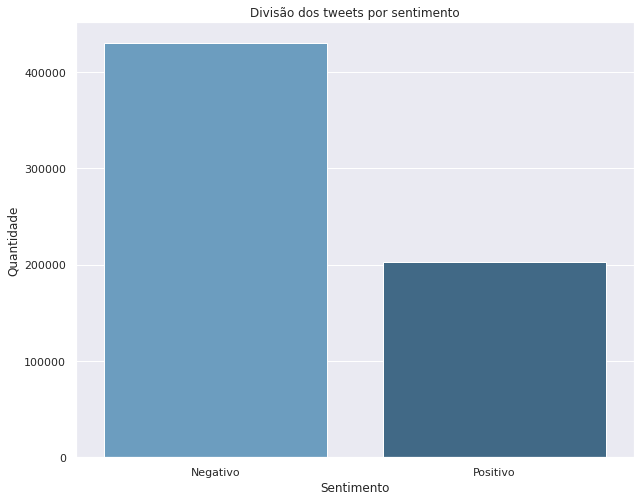

In [56]:
sentiments = formated_df["sentiment"].value_counts()
sns.set(rc={"figure.figsize": (10, 8)})
sns.barplot(x=sentiments.index, y=sentiments.values,     palette={"Positivo": "green", "Negativo": "red"}
plt.xlabel("Sentimento")
plt.ylabel("Quantidade")
plt.title("Divisão dos tweets por sentimento")

plt.show()


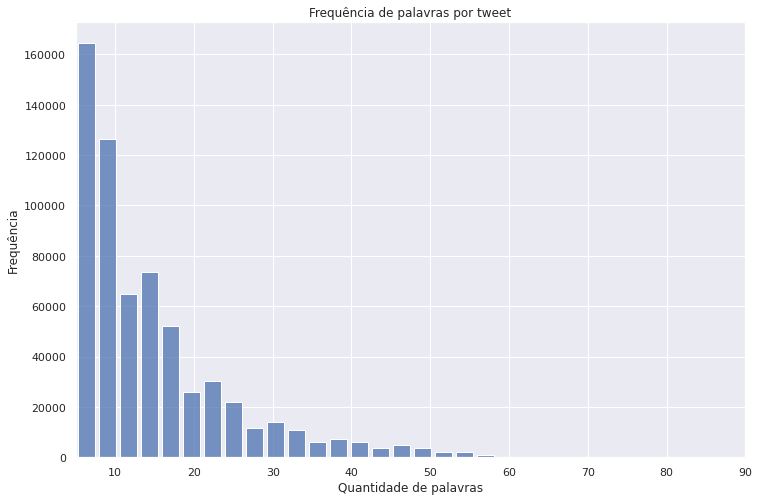

In [52]:
sns.set(rc={"figure.figsize": (12, 8)})
sns.histplot(data=formated_df, x="number_words", bins=30, shrink=0.8)

plt.xlabel("Quantidade de palavras")
plt.ylabel("Frequência")
plt.title("Frequência de palavras por tweet")
plt.xlim([5, 90])
plt.show()


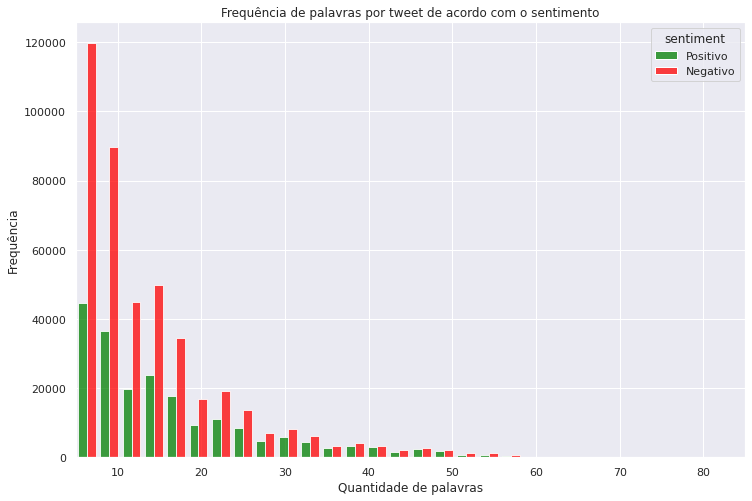

In [51]:
sns.set(rc={"figure.figsize": (12, 8)})
sns.histplot(
    data=formated_df,
    x="number_words",
    hue="sentiment",
    bins=30,
    palette={"Positivo": "green", "Negativo": "red"},
    multiple="dodge",
    shrink=0.8,
)
plt.xlabel("Quantidade de palavras")
plt.ylabel("Frequência")
plt.title("Frequência de palavras por tweet de acordo com o sentimento")
plt.xlim(5, 85)
plt.show()


In [10]:
df_positivo = formated_df.query("sentiment == 'Positivo'")
df_negativo = formated_df.query("sentiment == 'Negativo'")

positive_text = " ".join(df_positivo.tweet_text)
negative_text = " ".join(df_negativo.tweet_text)

positive_filter = remover_stop_words(positive_text)
negative_filter = remover_stop_words(negative_text)


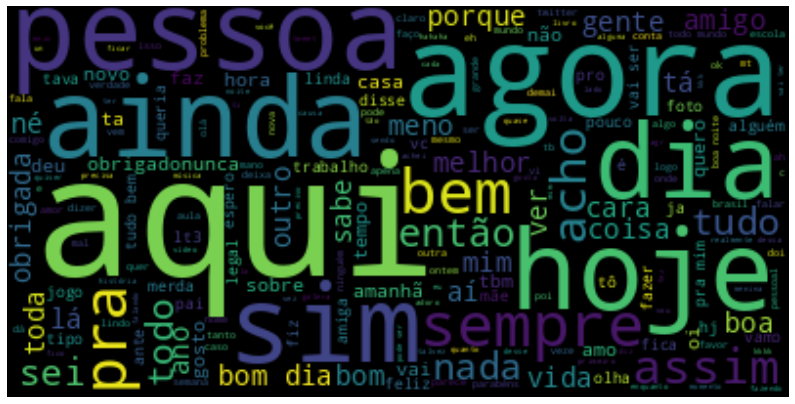

In [11]:
# Generate a word cloud image
wordcloud = WordCloud().generate(positive_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


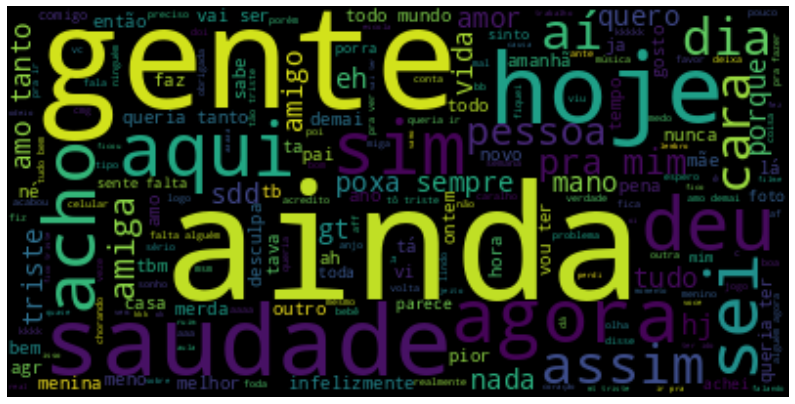

In [12]:
wordcloud = WordCloud().generate(negative_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


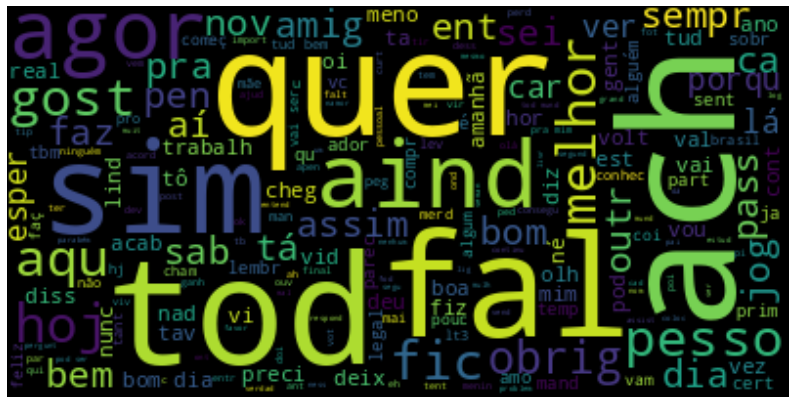

In [13]:
wordcloud = WordCloud().generate(stemming(positive_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


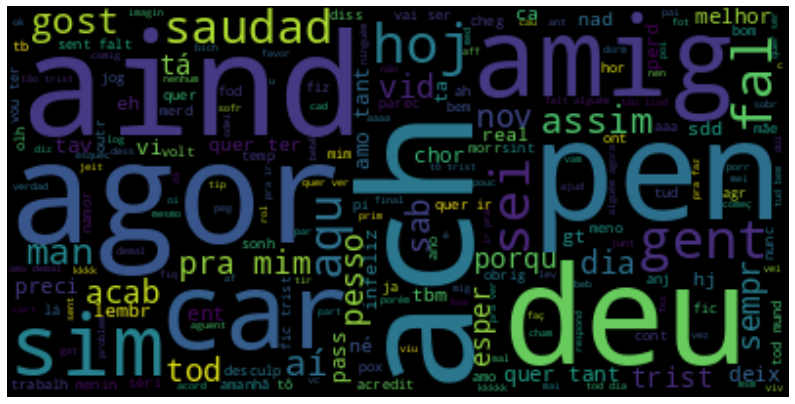

In [14]:
wordcloud = WordCloud().generate(stemming(negative_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [15]:
formated_df = formated_df.assign(
    day_period=formated_df.tweet_date.apply(
        lambda x: datetime_to_period(datetime_to_hour(x))
    )
)

formated_df


,tweet_text,tweet_date,sentiment,number_words,day_period
1,o meu like eu já dei na época,Tue Aug 21 04:32:55 +0000 2018,Positivo,8,overnight
2,eu só queria conseguir comer alguma coisa pra ...,Tue Aug 21 04:32:37 +0000 2018,Positivo,10,overnight
3,d que lindo dia !,Tue Aug 21 04:32:33 +0000 2018,Positivo,5,overnight
4,"pq da pr jeito!!é uma ""oferta"", ha q aproveitar p",Tue Aug 21 04:32:21 +0000 2018,Positivo,10,overnight
5,"eu entendi, mas isso foi mais porque eu pensei...",Tue Aug 21 04:32:03 +0000 2018,Positivo,13,overnight
...,...,...,...,...,...
785809,acordar 8 horas é tão bom,Fri Oct 12 11:10:01 +0000 2018,Positivo,6,morning
785810,"olá, mayck você já é cliente claro? caso não s...",Fri Oct 12 11:16:02 +0000 2018,Positivo,28,morning
785811,opa tava na merda mm e fiquei logo mais feliz ...,Fri Oct 12 11:12:49 +0000 2018,Positivo,14,morning
785812,foi como a tua lealdade,Fri Oct 12 11:11:24 +0000 2018,Positivo,5,morning


Text(0.5, 1.0, 'Frequência de tweets por período do dia')

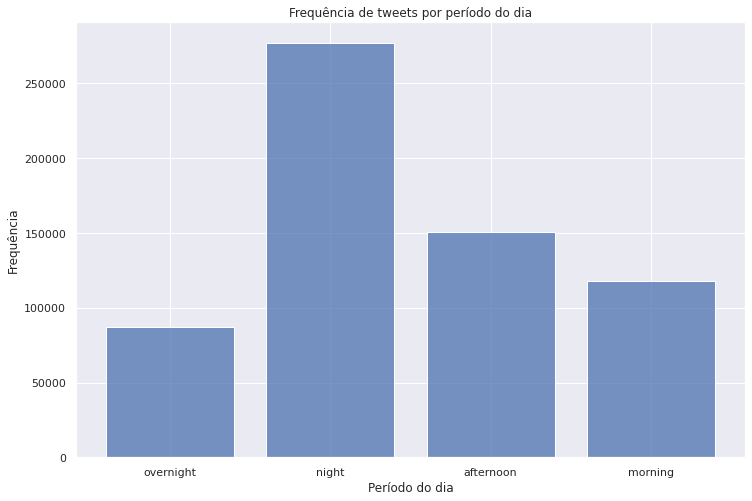

In [35]:
sns.histplot(data=formated_df, x="day_period", bins=5, shrink=0.8)
plt.xlabel("Período do dia")
plt.ylabel("Frequência")
plt.title("Frequência de tweets por período do dia")


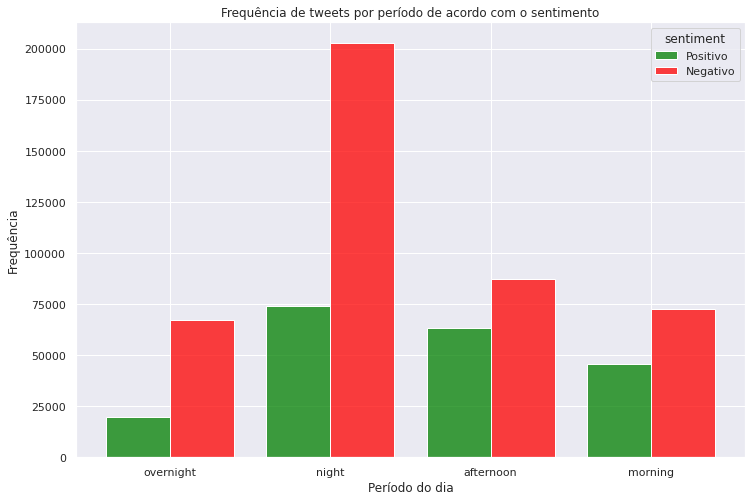

In [42]:
sns.histplot(
    data=formated_df,
    x="day_period",
    hue="sentiment",
    bins=5,
    palette={"Positivo": "green", "Negativo": "red"},
    multiple="dodge",
    shrink=0.8,
)
plt.xlabel("Período do dia")
plt.ylabel("Frequência")
plt.title("Frequência de tweets por período de acordo com o sentimento")
plt.show()
